In [ ]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
import pandas as pd

def load_data(filepath):
    """Load data with multiple encoding attempts"""
    encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

    for encoding in encodings:
        try:
            data = pd.read_csv(filepath, encoding=encoding)
            print(f"✅ Data loaded successfully with {encoding} encoding")
            print(f"📊 Dataset shape: {data.shape}")
            return data
        except Exception as e:
            print(f"❌ Failed with encoding {encoding}: {e}")
            continue

    raise ValueError("❌ Could not load data with any encoding")


In [ ]:
train_data = load_data('train2.csv')
print(f"\nDataset Info:")
print(f"Shape: {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")
print(f"\nFirst few rows:")
print(train_data.head())


✅ Data loaded successfully with utf-8 encoding
📊 Dataset shape: (54808, 14)

Dataset Info:
Shape: (54808, 14)
Columns: ['employee_id', 'department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']

First few rows:
   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

def preprocess_data(train_data, test_data=None, use_class_weights=True, random_state=42):
    """Preprocess data with pipeline and optional class weights"""
    print("⚙️ PREPROCESSING DATA")
    print("="*50)

    # Store employee IDs if present
    train_ids = train_data.pop('employee_id') if 'employee_id' in train_data.columns else None

    test_ids = test_data.pop('employee_id') if test_data is not None and 'employee_id' in test_data.columns else None

    # Separate features and target
    X_train = train_data.drop('is_promoted', axis=1, errors='ignore')
    y_train = train_data.get('is_promoted')

    if test_data is not None:
        X_test = test_data.drop('is_promoted', axis=1, errors='ignore')
        y_test = test_data.get('is_promoted')

    # Identify column types
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

    print(f"📊 Categorical features ({len(cat_cols)}): {cat_cols}")
    print(f"🔢 Numerical features ({len(num_cols)}): {num_cols}")

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ])

    # Fit and transform
    X_train_processed = preprocessor.fit_transform(X_train)

    # Get feature names for later use
    try:
        num_features = [f"num__{col}" for col in num_cols]
        cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
        feature_names = num_features + list(cat_features)
    except:
        feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

    # Compute class weights
    class_weights = None
    if use_class_weights and y_train is not None:
        print("⚖️ Computing class weights...")
        class_weights_arr = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(zip(np.unique(y_train), class_weights_arr))
        print(f"✅ Computed class weights: {class_weights}")

    result = {
        'X_train': X_train_processed,
        'y_train': y_train,
        'train_ids': train_ids,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'class_weights': class_weights
    }

    if test_data is not None:
        X_test_processed = preprocessor.transform(X_test)
        result.update({
            'X_test': X_test_processed,
            'y_test': y_test,
            'test_ids': test_ids
        })

    return result


In [ ]:
processed_data = preprocess_data(train_data, use_class_weights=True)

X_train = processed_data['X_train']
y_train = processed_data['y_train']
feature_names = processed_data['feature_names']
class_weights = processed_data['class_weights']

print(f"\n✅ Preprocessing completed!")
print(f"Training data shape: {X_train.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Class Weights: {class_weights}")


⚙️ PREPROCESSING DATA
📊 Categorical features (5): ['department', 'region', 'education', 'gender', 'recruitment_channel']
🔢 Numerical features (7): ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score']
⚖️ Computing class weights...
✅ Computed class weights: {np.int64(0): np.float64(0.5465496609493419), np.int64(1): np.float64(5.8706083976006855)}

✅ Preprocessing completed!
Training data shape: (54808, 53)
Number of features: 53
Class Weights: {np.int64(0): np.float64(0.5465496609493419), np.int64(1): np.float64(5.8706083976006855)}


In [ ]:
import joblib
joblib.dump(processed_data['preprocessor'], 'preprocessor.pkl')


['preprocessor.pkl']

In [ ]:
#traning fucntion

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def train_xgboost(X_train, y_train, cv_folds=5, random_state=42):
    """Train XGBoost with class weight handling"""
    print("🤖 TRAINING XGBOOST ONLY")
    print("="*50)

    # Compute scale_pos_weight for class imbalance
    pos = sum(y_train == 1)
    neg = sum(y_train == 0)
    scale_pos_weight = neg / pos
    print(f"⚖️ Class weight (scale_pos_weight): {scale_pos_weight:.2f}")

    # Define model
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=random_state
    )

    # Cross-validation
    print("🔄 Performing cross-validation...")
    scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='f1')
    print(f"✅ XGBoost - Mean F1 Score: {scores.mean():.4f} (±{scores.std():.4f})")

    # Train on full data
    print("🛠️ Training XGBoost on full data...")
    model.fit(X_train, y_train)
    print("🏁 Training complete.")

    return model


In [ ]:
#  training


# Train XGBoost model
xgb_model = train_xgboost(X_train, y_train)


print("\n✅ XGBoost training complete!")


🤖 TRAINING XGBOOST ONLY
⚖️ Class weight (scale_pos_weight): 10.74
🔄 Performing cross-validation...
✅ XGBoost - Mean F1 Score: 0.3818 (±0.0008)
🛠️ Training XGBoost on full data...
🏁 Training complete.

✅ XGBoost training complete!


In [ ]:
import joblib


joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_xgboost(model, X_test, y_test):
    """Evaluate XGBoost model with classification metrics and plots."""
    print("📊 MODEL EVALUATION")
    print("="*50)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"🎯 Accuracy:  {accuracy:.4f}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🎯 Recall:    {recall:.4f}")
    print(f"🎯 F1 Score:  {f1:.4f}")
    print(f"🎯 AUC-ROC:   {auc:.4f}")

    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='darkorange')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


📊 MODEL EVALUATION
🎯 Accuracy:  0.7637
🎯 Precision: 0.2593
🎯 Recall:    0.9557
🎯 F1 Score:  0.4079
🎯 AUC-ROC:   0.9365

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     50140
           1       0.26      0.96      0.41      4668

    accuracy                           0.76     54808
   macro avg       0.63      0.85      0.63     54808
weighted avg       0.93      0.76      0.81     54808



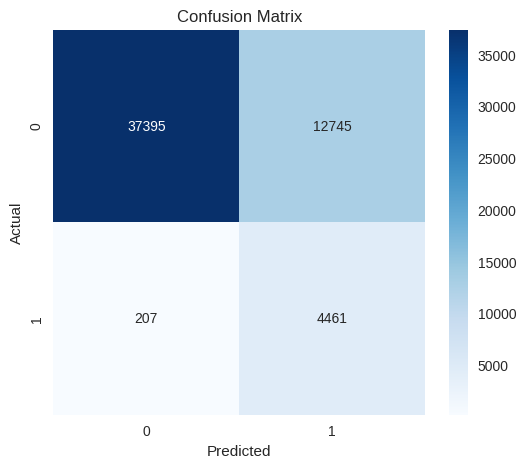

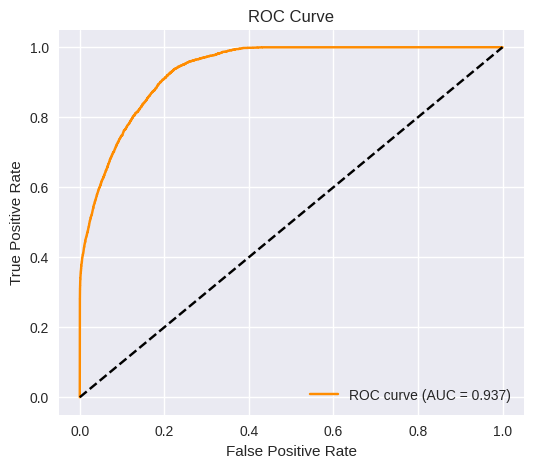

In [ ]:
# Evaluate the trained XGBoost model
evaluation_results = evaluate_xgboost(xgb_model, X_train, y_train)


In [ ]:
test_data = pd.read_csv('test2.csv')

print(test_data.columns)
print(test_data.head())

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score'],
      dtype='object')
   employee_id         department     region   education gender  \
0         8724         Technology  region_26  Bachelor's      m   
1        74430                 HR   region_4  Bachelor's      f   
2        72255  Sales & Marketing  region_13  Bachelor's      m   
3        38562        Procurement   region_2  Bachelor's      f   
4        64486            Finance  region_29  Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   24                   NaN   
1               other                1   31                   3.0   
2               other                1   31                   1.0   
3               other                3   31                 

In [ ]:
import pandas as pd
import joblib

# 1. Load raw test data
test_df = pd.read_csv('test2.csv')

# 2. Save and drop employee_id
employee_ids = test_df['employee_id']
X_test = test_df.drop('employee_id', axis=1)

# 3. Load preprocessor and trained model
preprocessor = joblib.load('preprocessor.pkl')
xgb_model = joblib.load('xgb_model.pkl')

# 4. Transform test data
X_test_processed = preprocessor.transform(X_test)

# 5. Make predictions
y_test_pred = xgb_model.predict(X_test_processed)
y_test_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

# 6. Create output DataFrame
output = pd.DataFrame({
    'employee_id': employee_ids,
    'is_promoted_pred': y_test_pred,
    'promotion_probability': y_test_pred_proba
})

# 7. Save to CSV
output.to_csv('test_predictions.csv', index=False)
print("✅ Predictions saved to test_predictions.csv")


✅ Predictions saved to test_predictions.csv


In [ ]:
pip install shap

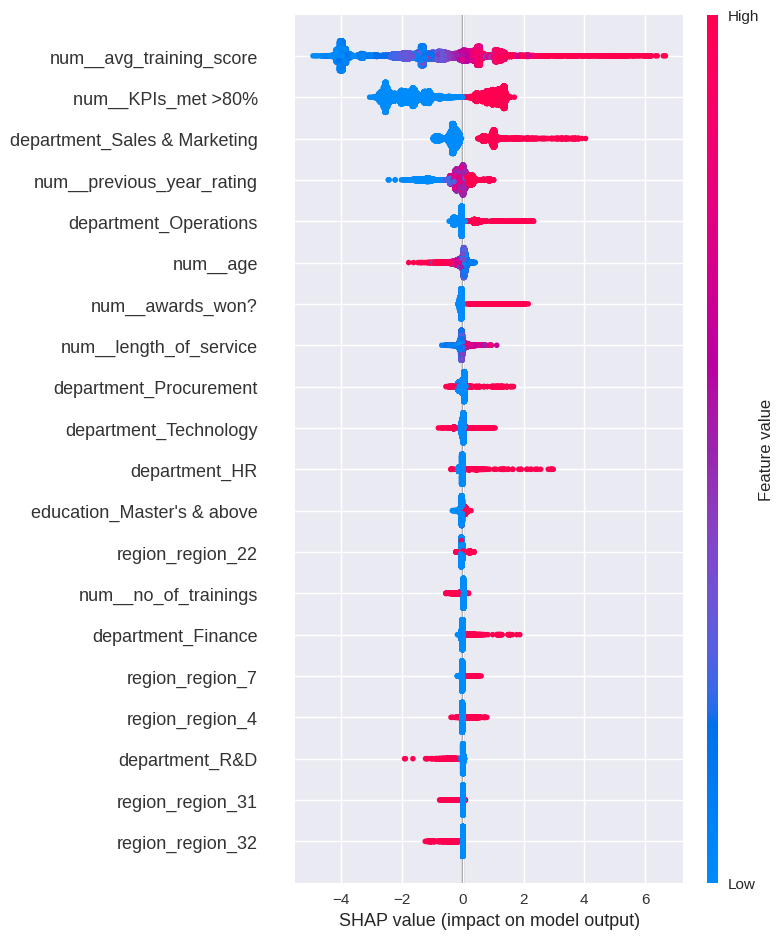

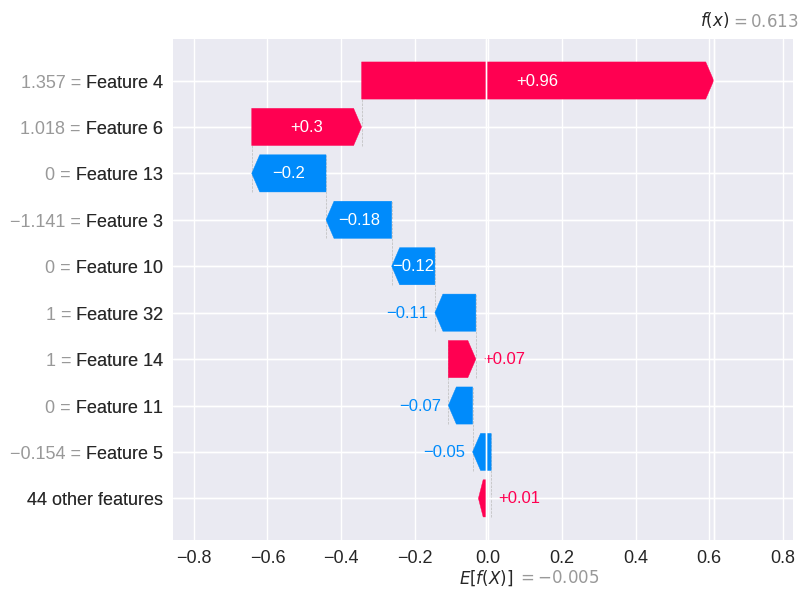

In [ ]:
import shap


explainer = shap.Explainer(xgb_model)


shap_values = explainer(X_test_processed)


shap.summary_plot(shap_values, features=X_test_processed, feature_names=feature_names)


shap.plots.waterfall(shap_values[0], max_display=10)


In [ ]:
!pip install transformers --quiet

from transformers import pipeline


llm = pipeline("text-generation", model="gpt2")


prompt = "Explain why the model predicted that the employee should be promoted. The top contributing features were: high performance rating, multiple trainings completed, and no history of previous promotions."

response = llm(prompt, max_length=100, do_sample=True, temperature=0.7)
print("LLM Explanation:\n", response[0]['generated_text'])


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


LLM Explanation:
 Explain why the model predicted that the employee should be promoted. The top contributing features were: high performance rating, multiple trainings completed, and no history of previous promotions.

Exclude that the model predicted that the employee should be promoted. The top contributing features were: high performance rating, multiple trainings completed, and no history of previous promotions. Provide an argument that the model predicted that the employee should be promoted. The top contributing features were: high performance rating, multiple trainings completed, and no history of previous promotions. Explain that the model predicted that the employee should be promoted. The top contributing features were: high performance rating, multiple trainings completed, and no history of previous promotions. This was a very valuable point of the article.

The model predicted that the employee should be promoted. The top contributing features were: high performance rating,

In [ ]:
pip install shap transformers xgboost pandas


In [ ]:
import shap
import pandas as pd
from transformers import pipeline
import joblib


model = joblib.load("xgb_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")
data = pd.read_csv("test2.csv")

In [ ]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00


In [26]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Widgets setup ---
feature_names = [
    'department', 'region', 'education', 'gender', 'recruitment_channel',
    'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
    'KPIs_met >80%', 'awards_won?', 'avg_training_score'
]

feature_widgets = {
    'department': widgets.Text(description='Department:'),
    'region': widgets.Text(description='Region:'),
    'education': widgets.Text(description='Education:'),
    'gender': widgets.Dropdown(options=['m', 'f'], description='Gender:'),
    'recruitment_channel': widgets.Text(description='Recruitment Channel:'),
    'no_of_trainings': widgets.IntText(description='No. Trainings:'),
    'age': widgets.IntText(description='Age:'),
    'previous_year_rating': widgets.FloatText(description='Prev. Rating:'),
    'length_of_service': widgets.IntText(description='Service (years):'),
    'KPIs_met >80%': widgets.IntText(description='KPI >80% (0/1):'),
    'awards_won?': widgets.IntText(description='Awards? (0/1):'),
    'avg_training_score': widgets.IntText(description='Avg Training Score:')
}
manual_entry_box = widgets.VBox([feature_widgets[f] for f in feature_names])
submit_btn = widgets.Button(description="Submit Manual Entry")

uploader = widgets.FileUpload(accept='.csv', multiple=False)
upload_btn = widgets.Button(description="Submit CSV Upload")

# New widgets for employee ID input after CSV upload
upload_employee_id_input = widgets.Text(
    description='Employee IDs (comma-separated):',
    placeholder='e.g. 101, 205, 309'
)
upload_predict_btn = widgets.Button(description="Predict for Entered IDs")

# Container to hold input and button together
upload_id_box = widgets.HBox([upload_employee_id_input, upload_predict_btn])

output = widgets.Output()

# --- Manual LLM+SHAP explanation ---
from transformers import pipeline
import shap

llm = pipeline("text2text-generation", model="google/flan-t5-base")

def explain_manual_row(row):
    # Prepare input features
    X = preprocessor.transform(pd.DataFrame([row]))
    pred = model.predict(X)[0]
    promotion_status = "PROMOTED" if pred == 1 else "NOT PROMOTED"

    # SHAP explanations
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Define non-actionable features to exclude
    non_actionable_features = [
        'num_age', 'age',
        'gender', 'gender_f', 'gender_m',
        'recruitment_channel', 'recruitment_channel_sourcing', 'recruitment_channel_other',
        'region_region_7', 'region_region_22', 'region_region_4', 'region_region_31', 'region_region_32',
        'num_length_of_service', 'length_of_service'
    ]

    features = pd.DataFrame([row]).columns
    feature_impact = sorted(zip(features, shap_values[0]), key=lambda x: abs(x[1]), reverse=True)

    actionable_factors = []
    non_actionable_factors = []
    processed_features = set()

    for name, shap_val in feature_impact:
        base_name = name.lower().replace('num_', '').replace('_', ' ').strip()
        if base_name in processed_features:
            continue
        processed_features.add(base_name)
        actual_value = row[name]
        is_non_actionable = any(non_actionable in name.lower() for non_actionable in non_actionable_features)
        factor_info = {
            'name': base_name,
            'value': actual_value,
            'impact': shap_val,
            'helped': shap_val > 0
        }
        if is_non_actionable:
            non_actionable_factors.append(factor_info)
        else:
            actionable_factors.append(factor_info)

    top_actionable = actionable_factors[:3]
    top_non_actionable = non_actionable_factors[:2]
    top_factors = top_actionable + top_non_actionable

    # Generate natural, human-like explanation
    try:
        positive_factors = []
        negative_factors = []

        def phrase_factor(factor):
            name = factor['name']
            val = factor['value']
            if 'award' in name:
                return "awards won" if val != 0 else "no awards won"
            elif 'training score' in name:
                return f"average training score of {val}"
            elif 'training' in name:
                return f"{val} training session{'s' if val != 1 else ''} completed"
            elif 'recruitment channel' in name:
                return f"recruited through the {val} channel"
            elif 'age' in name:
                return f"age {val}"
            else:
                return name.replace('_', ' ').capitalize() + (f" ({val})" if val is not None else "")

        for factor in top_factors:
            desc = phrase_factor(factor)
            if factor['helped']:
                positive_factors.append(desc)
            else:
                negative_factors.append(desc)

        if pred == 1:
            if positive_factors:
                explanation = f"The employee is predicted to be promoted due to strong performance in {', '.join(positive_factors)}."
            else:
                explanation = "The employee is predicted to be promoted."
            if negative_factors:
                explanation += f" While {', '.join(negative_factors)} worked against the decision."
        else:
            explanation = f"The employee is predicted to not be promoted due to {', '.join(negative_factors)}."
            if positive_factors:
                explanation += f" However, {', '.join(positive_factors)} provided some advantages."

        advice_parts = []
        for factor in top_actionable:
            if not factor['helped']:
                name = factor['name']
                if 'training score' in name:
                    advice_parts.append("improving training performance above 80")
                elif 'training' in name:
                    advice_parts.append("completing additional professional development courses")
                elif 'award' in name:
                    advice_parts.append("winning performance awards")
                else:
                    advice_parts.append(f"improving {name}")
        if advice_parts:
            explanation += " To improve future promotion prospects, focus on " + ", ".join(advice_parts) + "."

        return f"**DECISION: {promotion_status}**\n\n{explanation}"

    except Exception as e:
        return f"Error generating explanation: {e}"


def explain_prediction(emp_id):
    """Generate prediction and explanation for a specific employee ID from uploaded CSV"""
    global uploaded_df

    if uploaded_df is None:
        return "Error: No CSV data uploaded"

    # Find the employee in the uploaded data
    employee_data = uploaded_df[uploaded_df['employee_id'] == emp_id]

    if employee_data.empty:
        return f"Error: Employee ID {emp_id} not found in uploaded data"

    # Get the first (and should be only) matching row
    employee_row = employee_data.iloc[0]

    # Convert to dictionary, excluding employee_id column
    employee_dict = employee_row.drop('employee_id').to_dict()

    # Use the existing explain_manual_row function
    return explain_manual_row(employee_dict)

# --- Handlers ---
def on_manual_submit(b):
    with output:
        clear_output()
        # Collect manual entry data
        data = {f: feature_widgets[f].value for f in feature_names}
        df = pd.DataFrame([data])
        display(df)
        explanation = explain_manual_row(data)
        display(widgets.HTML(f"<pre>{explanation}</pre>"))

# Global variable to hold uploaded DataFrame
uploaded_df = None

def on_upload_submit(b):
    global uploaded_df
    with output:
        clear_output()
        if not uploader.value:
            print("Please upload a CSV file first.")
            return
        for filename, fileinfo in uploader.value.items():
            content = fileinfo['content']
            uploaded_df = pd.read_csv(pd.io.common.BytesIO(content))
            display(uploaded_df)
            if 'employee_id' not in uploaded_df.columns:
                print("CSV must contain an 'employee_id' column.")
                uploaded_df = None
                return
            # Display input box and predict button together
            display(upload_id_box)

def on_upload_predict(b):
    with output:
        # Do not clear output to keep CSV visible
        if uploaded_df is None:
            print("Please upload a valid CSV file first.")
            return
        entered_ids = upload_employee_id_input.value
        if not entered_ids.strip():
            print("Please enter at least one employee ID.")
            return
        try:
            id_list = [int(emp_id.strip()) for emp_id in entered_ids.split(",") if emp_id.strip()]
        except ValueError:
            print("Please enter valid integer employee IDs separated by commas.")
            return
        filtered_df = uploaded_df[uploaded_df['employee_id'].isin(id_list)]
        if filtered_df.empty:
            print("No matching employee IDs found in the uploaded CSV.")
            return
        for emp_id in id_list:
            print(f"\nPrediction and Explanation for Employee ID {emp_id}:")
            explanation = explain_prediction(emp_id)  # Now this function exists!
            display(widgets.HTML(f"<pre>{explanation}</pre>"))
            print("-" * 60)
        # Clear the input box after prediction
        upload_employee_id_input.value = ""

mode_selector = widgets.RadioButtons(
    options=['Upload CSV', 'Manual Entry'],
    description='Input mode:'
)

def handle_mode_change(change):
    with output:
        clear_output()
        if change['new'] == 'Upload CSV':
            display(uploader, upload_btn)
        else:
            display(manual_entry_box, submit_btn)

mode_selector.observe(handle_mode_change, names='value')
submit_btn.on_click(on_manual_submit)
upload_btn.on_click(on_upload_submit)
upload_predict_btn.on_click(on_upload_predict)

# Trigger initial display based on default value
handle_mode_change({'new': mode_selector.value})

display(mode_selector, output)

Device set to use cuda:0


RadioButtons(description='Input mode:', options=('Upload CSV', 'Manual Entry'), value='Upload CSV')

Output()